# riverbed parameters

Thanks to this script we will carry out an inversion of the parameters of the riverbed, t
The inversion will focus on the four uncertain parameters and one boundary condition of this model, namely:

- the porosity $n$
- the intinsic permeability k,
- the thermal condictivity, 
- the heat capacity, 



# 1. Initiation Ginnette files

In [6]:
#!/usr/bin/env python

import os
import numpy as np
from pathlib import Path
import pandas as pd
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display
import subprocess
import glob
import itertools
import seaborn as sns
import array


libs_gfortran = ['gfortran']
# please compile ginette in the folder 1D_col
# path of the 1D_col directory
os.chdir('/home/ariviere/Programmes/ginette/application/mini-LOMOS/GINETTE_SENSI/')
# Print the current working directory
print("Current working directory: {0}".format(os.getcwd()))

# if the directory does not exist, create it SENSI OUPUT
if not os.path.exists('SENSI'):
    os.makedirs('SENSI')
if not os.path.exists('OUTPUT'):
    os.makedirs('OUTPUT')   
    

    


#-----------------------------------------------------------------
# Compile ginette
if os.path.isfile('ginette'):
    print ("ginette exist")
else:
    print ("ginette not exist")
    print("you must compile ginette in the current directory")
    print(" gfortran -o ginette ../../src/ginette_V2.f")
    subprocess.call(["gfortran","-o","ginette","../../src/ginette_V2.f"])  #creat

#-----------------------------------------------------------------
########### Setup of the model

#time step in s
dt=900
#duration of the simulation in days
nb_day=30
date_simul_bg=pd.to_datetime("2022/04/14 14:00:00")
date_end_obs=pd.to_datetime("20/10/2022 15:15:00")
# state
## 0 steady state
# 1 transient state (dynamic state)
state=1
coef=0.01
ost=0
# size columnin meter
z_top=0.0
z_bottom=-0.4
az=abs(z_top-z_bottom)
#discretisation : size cell in meter
dz=0.01



# number of cell
nb_cell=az/dz



print("la simulation commence à",date_simul_bg)
#-----------------------------------------------------------------
## write the setup of the moddeled domain
f_param_bck=open("E_parametre_backup.dat", "r")
f_param_new = open("E_parametre.dat", 'w')
setup_model=f_param_bck.read()
setup_model=setup_model.replace('[dt]','%06.0fD+00' % dt)
setup_model=setup_model.replace('[state]','%1i' % state)
setup_model=setup_model.replace('[nb_day]','%06.0f' % nb_day)
setup_model=setup_model.replace('[z_top]', '%7.3e' % z_top)
setup_model=setup_model.replace('[z_bottom]', '%7.2e' % z_bottom)
setup_model=setup_model.replace('[az]','%7.3e' % az)
setup_model=setup_model.replace('[dz]','%6.2e' % dz)
setup_model=setup_model.replace('[nb_cell]','%05.0f' % nb_cell)

#Observation positions x 0.50000
#Observation in meter
Obs1=z_top-0.1
Obs2=z_top-0.2
Obs3=z_top-0.3
Obs4=z_top-0.4


## write the parameters

cell1=abs(Obs1/dz)
cell2=abs(Obs2/dz)
cell3=abs(Obs3/dz)
cell4=abs(Obs4/dz)
setup_model=setup_model.replace('[cell1]','%05.0f' % cell1)
setup_model=setup_model.replace('[cell2]','%05.0f' % cell2)
setup_model=setup_model.replace('[cell3]','%05.0f' % cell3)
setup_model=setup_model.replace('[cell4]','%05.0f' % cell4)
f_param_new.write(setup_model)
f_param_bck.close()
f_param_new.close()






Current working directory: /home/ariviere/Programmes/ginette/application/mini-LOMOS/GINETTE_SENSI
ginette exist
la simulation commence à 2022-04-14 14:00:00


/tmp/ipykernel_129471/3472095922.py:53: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  date_end_obs=pd.to_datetime("20/10/2022 15:15:00")


In [230]:
# number of facies in the column. If nb_zone=1 homognous porous media
nb_zone=2
#cote de la limitein meter, if you want more layer just add a new line
alt_thk=-0.11
# Write the parameters to calibrate    
param = ["k","l"]


#porosity
REF_n=0.8 # \omega
#-----------------------------------------------------------------
# constant parameters
## intrinsic permeability [m2]  k=K*mu/(rho*g)
## K hydraulic conductivity [m.s-1]
## mu viscosity [Pa.s]
## rho density [kg.m-3]
## g gravity  9.81 [m2.s-1]

# K=10**REF_k
REF_k=-13.5
# thermal conductivity [W.m-1.K-1]
REF_l=1 #
# Calculation of Heat capacity in Ginette  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# 1.5 e+6 4e+6
#rho_m imposed : 1000
# high slow
# density
# c_s solid specific heat capacity
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
#c_w=4185D+00	       m2/s2/C
#r_w=1000  kg/m3
# solid density r=val_r 
#REF_c=1000 fixed value
# solid grain density rho_s=val_r  [kg.m-3]
REF_r=3500





dvt_k = 0.5
dvt_n = 0.2
dvt_l=1
dvt_r=1000


# number of values by parameters
i_k = 1
i_l=4
i_r=5
i_n=4
if nb_zone==2:
    REF_n2=0.3 # \omega
# K=10**REF_k
    REF_k2=-13
# thermal conductivity [W.m-1.K-1]
    REF_l2=2.65 #
# solid grain density rho_s=val_r  [kg.m-3]
    REF_r2=3500
 #   REF_c=1000


    dvt_k2 = 1
    dvt_n2 = 0.1
    dvt_l2=1
    dvt_r2=1000
    i_l2=3
    i_k2=3
    i_r2=3
    i_n2=1

# if files exist in OUTPUT or SENSI delete them
files = glob.glob('OUTPUT/*')
for f in files:
    os.remove(f)
    print("file deleted",f)
files = glob.glob('SENSI/*')
for f in files:
    os.remove(f)
    print("file deleted",f)


file deleted OUTPUT/Ref_k_1e-14_Ref_l_1.2_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv
file deleted OUTPUT/Ref_k_1e-14_Ref_l_2.0_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv
file deleted OUTPUT/Ref_k_1e-14_Ref_l_1.6_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv
file deleted OUTPUT/Ref_k_1e-14_Ref_l_0.8_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv
file deleted SENSI/simulation_results.csv


# 2. Read observation data

In [231]:
# Définissez le répertoire où se trouvent les fichiers CSV
Obs_data = '../OBS_point/Point1Touques/'
# Obtenez la liste des fichiers dans le répertoire
fichiers = os.listdir(Obs_data)
print(fichiers)
info = None
all_data = None

for fichier in fichiers:
    if fichier.endswith('.csv'):
        if 'info' in fichier:
            info = pd.read_csv(os.path.join(Obs_data, fichier))
        elif 'deltaP' in fichier:
            all_data = pd.read_csv(os.path.join(Obs_data, fichier),sep=';')
        elif 'Temp' in fichier:
            temp_data = pd.read_csv(os.path.join(Obs_data, fichier),sep=';')    

all_data['dates']=pd.to_datetime(all_data['dates'],format='%d/%m/%Y %H:%M')
all_data=all_data[all_data['dates']>date_simul_bg]

temp_data['dates']=pd.to_datetime(temp_data['dates'],format='%d/%m/%Y %H:%M:%S')
temp_data=temp_data[temp_data['dates']>date_simul_bg]

all_data=all_data.merge( temp_data,on=['dates'])
# drop 2 columns # and ST2
all_data=all_data.drop(columns=['ST2','#'],inplace=False)
#rename columns
all_data.columns=['dates','deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Réindexer le DataFrame
all_data.reset_index(drop=True, inplace=True)
all_data['deltaP']=all_data['deltaP']*coef+ost


date_begin= all_data['dates'].iloc[0]
date_end = pd.to_datetime(date_begin) + pd.to_timedelta(nb_day, unit='d')
print(date_begin,date_end)
# pas de temps
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

# pas de temps=900s
is_equal_900_sec = all(time_diff == pd.Timedelta(seconds=900))

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])
all_data

['deltaP_Point1Touques_14_04_22.csv', 'T2_Point1Touques_14_04_22.csv', 'Temp_Point1Touques_14_04_22.csv']
2022-04-14 14:15:00 2022-05-14 14:15:00
Toutes les différences entre les lignes sont de 900 secondes.


,dates,deltaP,TempMolo,Temp1,Temp2,Temp3,Temp4
0,2022-04-14 14:15:00,-0.079848,12.690,10.533,10.391,10.213,10.099
1,2022-04-14 14:30:00,-0.079936,12.749,10.582,10.392,10.214,10.119
2,2022-04-14 14:45:00,-0.080023,12.846,10.591,10.394,10.216,10.121
3,2022-04-14 15:00:00,-0.080110,12.930,10.602,10.397,10.216,10.124
4,2022-04-14 15:15:00,-0.080196,12.998,10.612,10.400,10.217,10.125
...,...,...,...,...,...,...,...
18142,2022-10-20 13:45:00,-0.078094,14.530,13.904,13.646,13.401,13.285
18143,2022-10-20 14:00:00,-0.078184,14.553,13.901,13.646,13.403,13.287
18144,2022-10-20 14:15:00,-0.078274,14.578,13.903,13.646,13.404,13.290
18145,2022-10-20 14:30:00,-0.078364,14.607,13.901,13.646,13.406,13.291


In [232]:
# Trouver les horodatages qui ne commencent pas à des intervalles de 15 minutes et ajuster uniquement ceux-là
#mask = all_data['dates'].dt.minute % 15 != 0
#all_data.loc[mask, 'timestamps'] = all_data.loc[mask, 'dates'] - pd.to_timedelta(all_data.loc[mask, 'dates'].dt.minute % 15, unit='m')
# Réinitialiser les secondes à zéro pour tous les horodatages
all_data['dates'] = all_data['dates'].dt.floor('min')
all_data['dates'] = all_data['dates'].dt.floor('15T')


In [233]:

all_data['timestamps']=all_data['dates']

# Créez un nouvel index avec des dates toutes les 15 minutes
new_index = pd.date_range(start=all_data['timestamps'].min(), end=all_data['timestamps'].max(), freq='15T')

# Réindexez le DataFrame pour inclure ces nouvelles dates
all_data = all_data.set_index('timestamps').reindex(new_index)
# Sélection des colonnes pour l'interpolation
columns_to_interpolate = ['deltaP', 'TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']

# Appliquez l'interpolation uniquement sur la colonne 'valeur'
all_data[columns_to_interpolate] = all_data[columns_to_interpolate].interpolate(method='time')




In [234]:

# Vérification des écarts temporels après l'interpolation
time_diff = all_data['dates'].diff().dropna()
indices_not_equal_900_sec = time_diff[time_diff != pd.Timedelta(seconds=900)].index

if len(indices_not_equal_900_sec) == 0:
    print("Toutes les différences entre les lignes sont de 900 secondes.")
else:
    print("Les différences ne sont pas toutes de 900 secondes. Voici les indices concernés :")
    print(indices_not_equal_900_sec)
    # Afficher les lignes correspondantes dans le dataframe
    print(all_data.loc[indices_not_equal_900_sec])

Toutes les différences entre les lignes sont de 900 secondes.


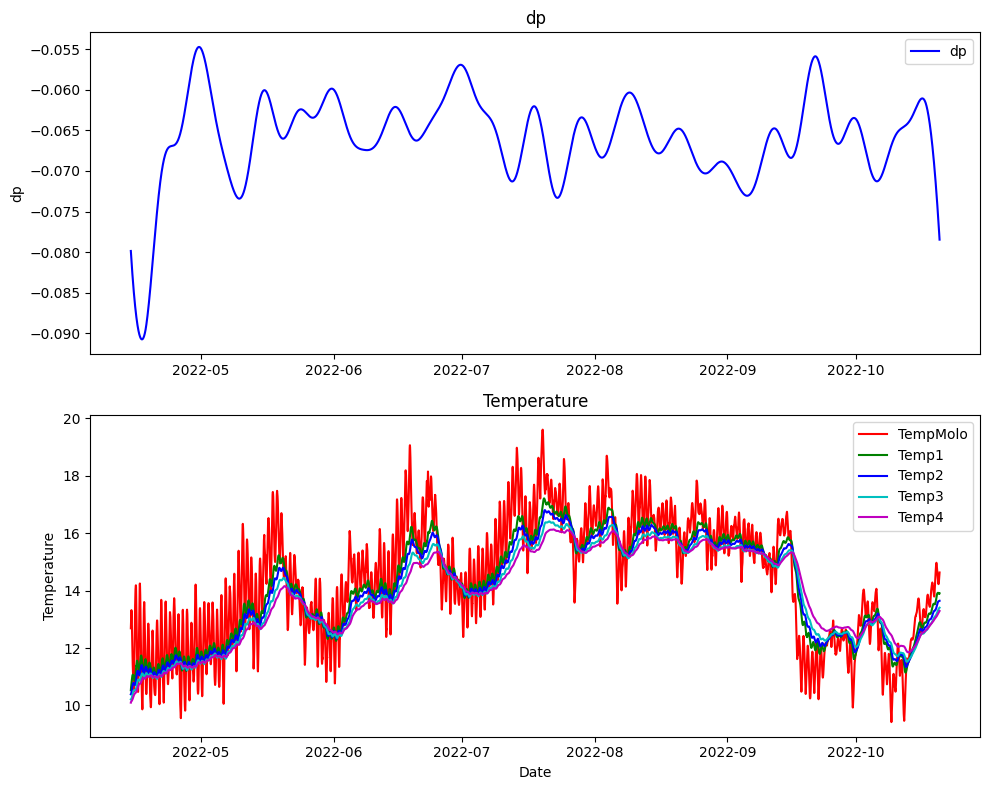

In [235]:

# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(all_data['dates'], all_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(all_data['dates'], all_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()

# Zoom temperature



In [236]:
filtered_data = all_data[(all_data['dates'] > '2022-04-01') & (all_data['dates'] < '2022-05-16')]


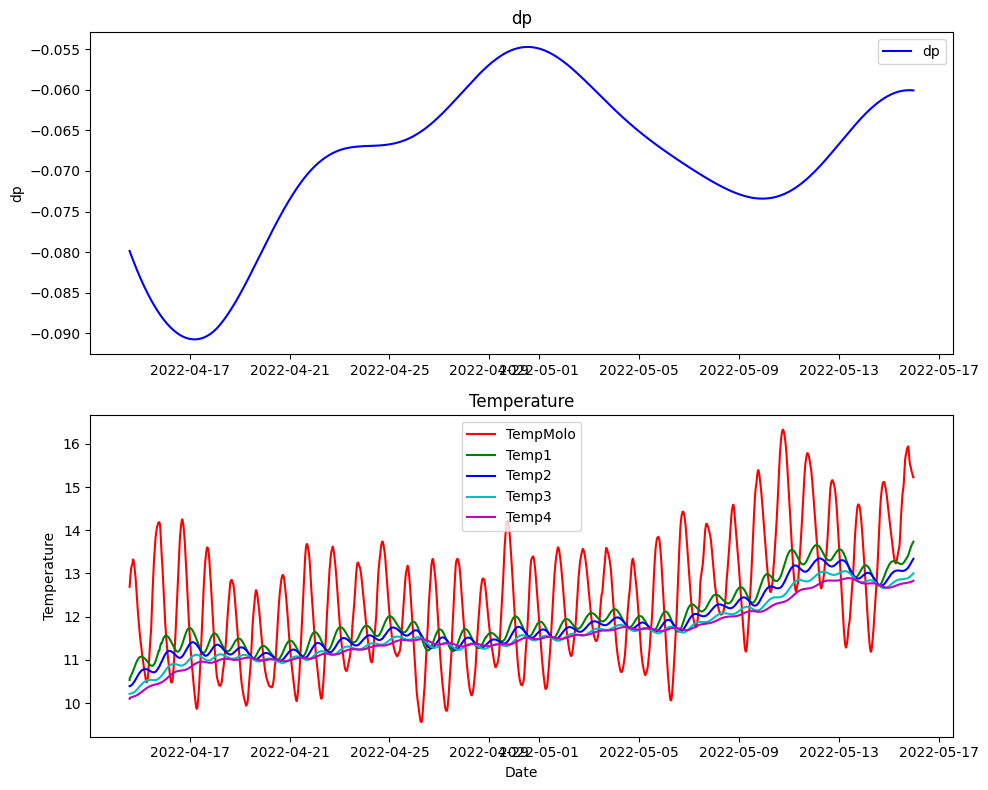

In [237]:
# Creating subplots for 'dp' and 'temp' graphs vertically
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plotting 'dp'
ax1.plot(filtered_data['dates'],filtered_data['deltaP'], 'b-', label='dp')
ax1.set_ylabel('dp')
ax1.set_title('dp')
ax1.legend()

# Plotting 'Temps'
temp_columns = ['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']
colors = ['r', 'g', 'b', 'c', 'm']
for i, col in enumerate(temp_columns):
    ax2.plot(filtered_data['dates'], filtered_data[col], color=colors[i], label=col)

ax2.set_xlabel('Date')
ax2.set_ylabel('Temperature')
ax2.set_title('Temperature')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

plt.show()



## 2. Reference simulation and sampling



In [238]:
########### Zone of parameters
f_coor=open("E_coordonnee.dat", "w")
f_zone=open("E_zone.dat", 'w')

coord=pd.DataFrame()    

                      
    
# Coodrinate  
zvalues =  np.sort(np.arange(z_bottom+dz/2,dz/2,dz ))

xvalues = np.array([0.5])
zz, xx = np.meshgrid(zvalues, xvalues)
NT = np.product(zz.shape)
data = {
    "x": np.reshape(xx,NT),
    "z": np.reshape(zz,NT)}
coord = pd.DataFrame(data=data)
coord['id']=coord.index.values.astype(int)
coord['id']=coord['id']+1
cols = coord.columns.tolist()
cols = cols[-1:] + cols[:-1]
coord = coord[cols] 
coord.to_csv(f_coor, index = False, sep=' ', header=False)
#zone parameter by cell ((homogenous domain = 1 zone))
coord['zone'] =1


#Pour plusieurs zones modification AR
if nb_zone >= 2:
        coord['zone'] = np.where(coord['z'] >= alt_thk, 2,coord['zone'])
#Write new ginette files


coord.zone.to_csv(f_zone, index = False, header=False)

# close files    
f_zone.close()
f_coor.close()


# Inital conditions
f_temp_IC=open("E_temperature_initiale.dat","w")
initial_temps = all_data.iloc[0][['TempMolo', 'Temp1', 'Temp2', 'Temp3', 'Temp4']]
z_temps = np.array([z_top+0.005, Obs1, Obs2, Obs3, Obs4])
initial = pd.DataFrame({'z': z_temps, 'T': initial_temps})
initial['z'] = initial['z'].astype(float)
initial['T'] = initial['T'].astype(float)


# Define the range of depths for interpolation
z_values = np.arange(z_bottom+dz/2, z_top+0.001, dz)  # Depth range from -0.4 to 0.005

# Perform linear interpolation
Temp_init = np.interp(z_values, initial['z'][::-1], initial['T'][::-1])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_temp = {
    'z': z_values,
    'T': Temp_init
}

interpolated_temp = pd.DataFrame(interpolated_temp)
interpolated_temp_sorted = interpolated_temp.sort_values(by='z', ascending=False)

interpolated_temp_sorted['T'].to_csv(f_temp_IC, index = False, sep='\n', header=False)

# To apply dp to the column, we need to convert it to a pressure value
f_chg_IC=open("E_charge_initiale.dat","w")
initial_pres = all_data.iloc[0][['deltaP']]*-1
initial_chg = pd.DataFrame({'z': [z_bottom], 'chg': [0]})
new_row = pd.DataFrame({'z': [0], 'chg':initial_pres})
initial_chg = pd.concat([initial_chg, new_row], ignore_index=True)
initial_chg['z'] = initial_chg['z'].astype(float)
initial_chg['chg'] = initial_chg['chg'].astype(float)
z_values = np.arange(z_bottom+dz/2, z_top+0.001, dz)


# Perform linear interpolation
charge_init = np.interp(z_values, initial_chg['z'][:], initial_chg['chg'][:])  # Reversed to align with depths

# Creating a DataFrame for the interpolated data
interpolated_chg = {
    'z': z_values,
    'chg': charge_init
}
interpolated_chg = pd.DataFrame(interpolated_chg)
interpolated_chg_sorted = interpolated_chg.sort_values(by='z', ascending=False)



interpolated_chg_sorted['chg'].to_csv(f_chg_IC, index = False, sep='\n', header=False)

f_chg_IC.close()
f_temp_IC.close()

# Boundary conditions
all_data['bot']=0
all_data['top']=all_data['deltaP']
all_data[['top','bot']].to_csv('E_charge_t.dat', sep=' ', index=False, header=False)
all_data[['TempMolo', 'Temp4']].to_csv('E_temp_t.dat', sep=' ', index=False, header=False)


In [239]:
import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff_sensor = f'Diff_Temp{i}'

        diff = data[diff_sensor]
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics


## 2. Screening parmeters



### 2.1 loop table param



In [240]:
parameter_table = pd.DataFrame()
if nb_zone==1:
    # Générer les plages de valeurs
    ranges = {
    'k': [REF_k - dvt_k, REF_k + dvt_k],
    'n': [REF_n - dvt_n, REF_n + dvt_n],
    'l': [REF_l - dvt_l, REF_l + dvt_l],
    'r': [REF_r - dvt_r, REF_r + dvt_r]}
    # Ajuster les plages de valeurs selon les conditions spécifiées
    if ranges['l'][0] <= 0.8:
        ranges['l'][0] = 0.8
    if ranges['n'][0] <= 0:
        ranges['n'][0] = 0.05
    
    # Afficher les informations pour 1 zone
    print("1 zone:")
    print(param)
    print(ranges['n'], ranges['k'],REF_k,dvt_k,REF_k - dvt_k)
    
if nb_zone==2:
    # Générer les plages de valeurs
    ranges = {
    'k': [REF_k - dvt_k, REF_k + dvt_k],
    'n': [REF_n - dvt_n, REF_n + dvt_n],
    'l': [REF_l - dvt_l, REF_l + dvt_l],
    'r': [REF_r - dvt_r, REF_r + dvt_r],
    'k2': [REF_k2 - dvt_k2, REF_k2 + dvt_k2],
    'n2': [REF_n2 - dvt_n2, REF_n2 + dvt_n2],
    'l2': [REF_l2 - dvt_l2, REF_l2 + dvt_l2],
    'r2': [REF_r2 - dvt_r2, REF_r2 + dvt_r2]}  
    # Ajuster les plages de valeurs selon les conditions spécifiées
    if ranges['l'][0] < 0.8:
        ranges['l'][0] = 0.8
    if ranges['n'][0] < 0:
        ranges['n'][0] = 0.05
    # Ajuster les plages de valeurs selon les conditions spécifiées
    if ranges['l2'][0] < 0.8:
        ranges['l2'][0] = 0.8
    if ranges['n2'][0] < 0:
        ranges['n2'][0] = 0.05        
    
    # Afficher les informations pour 1 zone
    print("2 zone:")
    print(param)
    print(ranges['n'], ranges['k'])
    
    

                  
 # number parameter in param
nb_param = len(param)
#
# Générer les valeurs des paramètres
values = {}


for p in param:
    if p in ranges:
        if p == 'k':
            values[p] = np.power(10, np.linspace(ranges[p][0], ranges[p][1], i_k))
        elif p == 'n':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_n)
        elif p == 'l':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_l)
        elif p == 'r':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_r)
        elif p == 'k2':
            values[p] = np.power(10, np.linspace(ranges[p][0], ranges[p][1], i_k2))
        elif p == 'n2':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_n2)
        elif p == 'l2':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_l2)
        elif p == 'r2':
            values[p] = np.linspace(ranges[p][0], ranges[p][1], i_r2)

# Générer les combinaisons de paramètres
parameter_combinations = list(itertools.product(*(values[p] for p in param)))
parameter_table = pd.DataFrame(parameter_combinations, columns=param)

# Afficher le tableau des paramètres
print(parameter_table)





2 zone:
['k', 'l']
[0.6000000000000001, 1.0] [-14.0, -13.0]
              k    l
0  1.000000e-14  0.8
1  1.000000e-14  1.2
2  1.000000e-14  1.6
3  1.000000e-14  2.0


### 2.5 Misfit function

In [241]:
def rmse(predictions, ref,sigma):
    differences = ((predictions - ref)/sigma)                      #the DIFFERENCEs.
    differences_squared = differences ** 2                    #the SQUAREs of ^
    mean_of_differences_squared = differences_squared.mean()  #the MEAN of ^
    rmse_val = np.sqrt(mean_of_differences_squared)           #ROOT of ^

    return rmse_val


import numpy as np

def calculate_metrics(data):
    metrics = {}

    for i in range(1, 4):
        sensor = f'Temp{i}'
        diff = data[f'{sensor}_sim'] - data[f'{sensor}_obs']
        
        rmse = np.sqrt(np.mean(diff**2))  # RMSE
        mae = np.mean(np.abs(diff))  # MAE
        bias = 100 * np.sum(diff) / np.sum(np.abs(data[f'{sensor}_obs']))  # PBias

        std_obs = data[f'{sensor}_obs'].std()
        std_sim = data[f'{sensor}_sim'].std()
        mean_obs = data[f'{sensor}_obs'].mean()
        mean_sim = data[f'{sensor}_sim'].mean()

        kge = 1 - np.sqrt((np.square(std_sim/std_obs - 1)) +
                            (np.square(mean_sim/mean_obs - 1)) +
                            (np.square(rmse/std_obs - 1)))

        metrics[sensor] = {'RMSE': rmse, 'MAE': mae, 'PBias': bias, 'KGE': kge}

    return metrics


#### Constant parameters

In [242]:
REF_k = 10**REF_k
REF_l = REF_l
REF_n = REF_n
REF_r = REF_r
if nb_zone==2:
    REF_k2 = 10**REF_k2
    REF_l2 = REF_l2
    REF_n2 = REF_n2
    REF_r2 = REF_r2

### 2.6 loops of simulations
delete the constant parameter for parameter in param

In [243]:
if nb_zone == 1:
    criteria = pd.DataFrame(columns=['k','l','n','r', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
if nb_zone == 2:
    criteria = pd.DataFrame(columns=['k','l','n','r','k2','l2','n2','r2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
obs_temp = all_data[all_data['dates'] < date_end]
# Valeurs de référence par défaut


for i in parameter_table.index:
    print(i)
    if nb_zone == 1:
        criteria_i = pd.DataFrame(columns=['k','l','n','c', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    if nb_zone == 2:
        criteria_i=pd.DataFrame(columns=['k','l','n','r','k2','l2','n2','r2', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])

# Mise à jour des valeurs de référence en fonction des paramètres présents dans param
    for p in param:
        if p == 'k':
            REF_k = parameter_table.loc[i, 'k']
        elif p == 'l':
            REF_l = parameter_table.loc[i, 'l']
        elif p == 'n':
            REF_n = parameter_table.loc[i, 'n']
        elif p == 'r':
            REF_r = parameter_table.loc[i, 'r']
        elif p == 'k2':
            REF_k2 = parameter_table.loc[i, 'k2']
        elif p == 'l2':
            REF_l2 = parameter_table.loc[i, 'l2']
        elif p == 'n2':
            REF_n2 = parameter_table.loc[i, 'n2']
        elif p == 'r2':
            REF_r2 = parameter_table.loc[i, 'r2']    

    print('k=',REF_k,'l=',REF_l,'n=',REF_n,'r=',REF_r)
    if(nb_zone==2):
        print('k2=',REF_k2,'l2=',REF_l2,'n2=',REF_n2,'r2=',REF_r2)
    criteria_i['k'] = [REF_k]
    criteria_i['l'] = [REF_l]
    criteria_i['n'] = [REF_n]
    criteria_i['r'] = [REF_r]
    # write the setup of the parameter zone file
    # read E_zone_parameter.dat
    f_paramZ_new = open("E_zone_parameter.dat", 'w')

    if nb_zone == 1:
        # read E_zone_parameter_backup.dat
        f_paramZ_bck = open("E_zone_parameter_backup.dat", "r")
        param_zone = f_paramZ_bck.read()
    # replace the parameter values
        param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
        param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
        param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
        param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
    # FILEPATH: /home/ariviere/Programmes/ginette/application/mini-LOMOS/grid_search_ginette_2PTT.ipynb
    if nb_zone == 2:
        criteria_i['k2'] = [REF_k2]
        criteria_i['l2'] = [REF_l2]
        criteria_i['n2'] = [REF_n2]
        criteria_i['r2'] = [REF_r2]
        f_param_bck.close()
        f_paramZ_bck = open("E_zone_parameter_backup_2zones.dat", "r")
        param_zone = f_paramZ_bck.read()
        param_zone = param_zone.replace('[k1]', '%8.2e' % REF_k)
        param_zone = param_zone.replace('[n1]', '%6.2f' % REF_n)
        param_zone = param_zone.replace('[l1]', '%6.2f' % REF_l)
        param_zone = param_zone.replace('[r1]', '%6.2f' % REF_r)
        param_zone = param_zone.replace('[k2]', '%8.2e' % REF_k2)
        param_zone = param_zone.replace('[n2]', '%6.2f' % REF_n2)
        param_zone = param_zone.replace('[l2]', '%6.2f' % REF_l2)
        param_zone = param_zone.replace('[r2]', '%6.2f' % REF_r2)

    f_paramZ_new.write(param_zone)
    f_paramZ_new.close()
    f_paramZ_bck.close()

    # run ginette
    subprocess.call(["./ginette"])

    # save the results
    # Colonnes pour les températures
    column_names = ['Temp_1', 'Temp_2', 'Temp_3']

    # Liste pour stocker les DataFrames
    all_dfs = []
    # Lire et stocker les DataFrames
    for i in range(1, 4):
        file_path = f'Sim_temperature_maille{i}_t.dat'
        df = pd.read_csv(file_path, sep='\s+', header=None, names=['Time', f'Temp{i}'])
        all_dfs.append(df)

    # Fusionner les DataFrames sur la colonne 'Time'
    sim_temp = all_dfs[0]  # Utiliser le premier DataFrame comme base

    for df in all_dfs[1:]:
        sim_temp = pd.merge(sim_temp, df, on='Time', how='outer')

    # Trier les colonnes par ordre numérique
    sim_temp = sim_temp.reindex(sorted(sim_temp.columns), axis=1)
    sim_temp['dates'] = pd.to_datetime(date_simul_bg) + pd.to_timedelta(sim_temp['Time'], unit='s')

    # save files with parameters in the name files
    if nb_zone==1:
        filename = "OUTPUT/Ref_k_{}_Ref_l_{}_Ref_n_{}_Ref_r_{}.csv".format(REF_k, REF_l, REF_n, REF_r)
    if nb_zone==2:
        filename = "OUTPUT/Ref_k_{}_Ref_l_{}_Ref_n_{}_Ref_r_{}_Ref_k2_{}_Ref_l2_{}_Ref_n2_{}_Ref_r2_{}.csv".format(REF_k, REF_l, REF_n, REF_r,REF_k2,REF_l2,REF_n2,REF_r2)    
    sim_temp.to_csv(filename, index=False)
        # Fusionner les DataFrames en fonction des dates communes
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
  
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
    metrics_dict = calculate_metrics(obs_sim)
    # Affichage des résultats
    # Loop through each sensor and save the metrics to the dataframe
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']
            
  # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True)
        

# Save the dataframe to a CSV file
criteria.to_csv('SENSI/simulation_results.csv', index=False)



0
k= 1e-14 l= 0.8 n= 0.8 r= 3500
k2= 1e-13 l2= 2.65 n2= 0.3 r2= 3500


/tmp/ipykernel_129471/1504002489.py:140: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  criteria=pd.concat([criteria,criteria_i],ignore_index=True)


1
k= 1e-14 l= 1.2 n= 0.8 r= 3500
k2= 1e-13 l2= 2.65 n2= 0.3 r2= 3500
2
k= 1e-14 l= 1.6 n= 0.8 r= 3500
k2= 1e-13 l2= 2.65 n2= 0.3 r2= 3500
3
k= 1e-14 l= 2.0 n= 0.8 r= 3500
k2= 1e-13 l2= 2.65 n2= 0.3 r2= 3500


In [244]:

# find file with Ref_k
path = os.getcwd()
path_output = os.path.join(path, 'OUTPUT')
files = os.listdir(path_output)
files_csv = [f for f in files if f[-3:] == 'csv']
files_csv = [f for f in files_csv if 'Ref_k' in f]


# Create a list of dataframes with the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the name
dfs = []

for file in files_csv:
    obs_sim = pd.DataFrame()
    df = pd.read_csv(os.path.join(path_output,file))
    # add the value of Ref_k  Ref_k2 Ref_l Ref_l2 in the dataframe
    df['Ref_k'] = file.split('_')[2]
    df['Ref_l'] = file.split('_')[5]
    df['Ref_n'] = file.split('_')[8]
    df['Ref_r'] = file.split('_')[11]
    # remove .csv fro df['Ref_l2]
    df['Ref_r'] = df['Ref_r'].str.replace('.csv', '')
    df['Ref_k'] = df['Ref_k'].astype(float)
    df['Ref_l'] = df['Ref_l'].astype(float)
    df['Ref_n'] = df['Ref_n'].astype(float)
    # calculate crietria
    df['dates']= pd.to_datetime(df['dates'])
    sim_temp = df
    
    criteria_i=pd.DataFrame(columns=['k','l','n','r', 'RMSE1', 'MAE1', 'PBias1', 'KGE1','RMSE2', 'MAE2', 'PBias2', 'KGE2','RMSE3', 'MAE3', 'PBias3', 'KGE3'])
    criteria_i['k'] = [df['Ref_k'][0]]
    
    criteria_i['l'] = [df['Ref_l'][0]]
    criteria_i['n'] = [df['Ref_n'][0]]
    criteria_i['r'] = [df['Ref_r'][0]]
    # Loop through each sensor and save the metrics to the dataframe
    obs_sim = pd.merge(obs_temp, sim_temp, on='dates', how='inner')
    obs_sim = obs_sim.rename(columns={
    'Temp1_x': 'Temp1_obs',
    'Temp2_x': 'Temp2_obs',
    'Temp3_x': 'Temp3_obs',
    'Temp1_y': 'Temp1_sim',
    'Temp2_y': 'Temp2_sim',
    'Temp3_y': 'Temp3_sim'})
  
    metrics_dict = calculate_metrics(obs_sim)
    for sensor, metrics in metrics_dict.items():
        if sensor == 'Temp1':
            criteria_i['RMSE1'] = metrics['RMSE']
            criteria_i['MAE1'] = metrics['MAE']
            criteria_i['PBias1'] = metrics['PBias']
            criteria_i['KGE1'] = metrics['KGE']
            
        elif sensor == 'Temp2':
            criteria_i['RMSE2'] = metrics['RMSE']
            criteria_i['MAE2'] = metrics['MAE']
            criteria_i['PBias2'] = metrics['PBias']
            criteria_i['KGE2'] = metrics['KGE']
        elif sensor == 'Temp3':
            criteria_i['RMSE3'] = metrics['RMSE']
            criteria_i['MAE3'] = metrics['MAE']
            criteria_i['PBias3'] = metrics['PBias']
            criteria_i['KGE3'] = metrics['KGE']


    # concatene the criteria_i to the criteria
    criteria=pd.concat([criteria,criteria_i],ignore_index=True) 


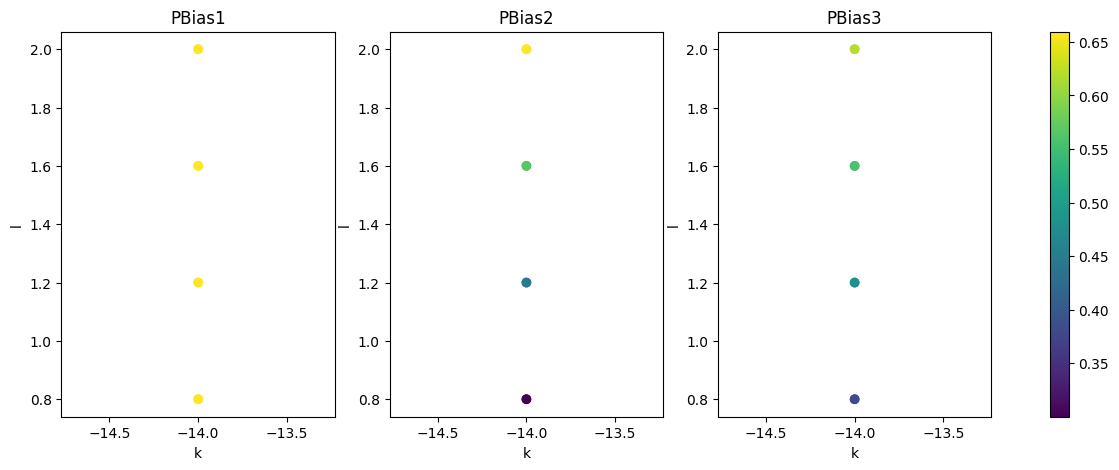

In [245]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of PBias1, PBias2, and PBias3
min_PBias = min(criteria[['PBias1', 'PBias2', 'PBias3']].min())
max_PBias = max(criteria[[ 'PBias2', 'PBias3']].max())

# Create a normalization instance
norm = Normalize(vmin=min_PBias, vmax=max_PBias)

for p in param:
    if p == 'k' and 'l' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('l')
        axs[0].set_title('PBias1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('l')
        axs[1].set_title('PBias2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('l')
        axs[2].set_title('PBias3')
    elif p == 'k' and 'n' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('n')
        axs[0].set_title('PBias1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('n')
        axs[1].set_title('PBias2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('n')
        axs[2].set_title('PBias3')
    elif p == 'k' and 'r' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('r')
        axs[0].set_title('PBias1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('r')
        axs[1].set_title('PBias2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('r')
        axs[2].set_title('PBias3')
    elif p == "k2" and 'l2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k2')
        axs[0].set_ylabel('l2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k2')
        axs[1].set_ylabel('l2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k2')
        axs[2].set_ylabel('l2')
        axs[2].set_title('PBias3')
    elif p == "k2" and 'n2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k2')
        axs[0].set_ylabel('n2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k2')
        axs[1].set_ylabel('n2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k2')
        axs[2].set_ylabel('n2')
        axs[2].set_title('PBias3')
    elif p == "k2" and 'r2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['r2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k2')
        axs[0].set_ylabel('r2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['r2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k2')
        axs[1].set_ylabel('r2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['r2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k2')
        axs[2].set_ylabel('r2')
        axs[2].set_title('PBias3')
    elif p=="k" and 'k2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('k2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('k2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('k2')
        axs[2].set_title('PBias3')
    elif p=="l" and 'l2' in param:
        scatter1 = axs[0].scatter(criteria['l'], criteria['l2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('l')
        axs[0].set_ylabel('l2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(criteria['l'], criteria['l2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('l')
        axs[1].set_ylabel('l2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(criteria['l'], criteria['l2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('l')
        axs[2].set_ylabel('l2')
        axs[2].set_title('PBias3')
    elif p=="k" and "l2" in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['l2'], c=criteria['PBias1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('l2')
        axs[0].set_title('PBias1')
        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l2'], c=criteria['PBias2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('l2')
        axs[1].set_title('PBias2')
        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l2'], c=criteria['PBias3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('l2')
        axs[2].set_title('PBias3')

           
    # Ajoutez d'autres conditions selon les combinaisons de paramètres nécessaires

# Créer une seule barre de couleur en utilisant le premier scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()

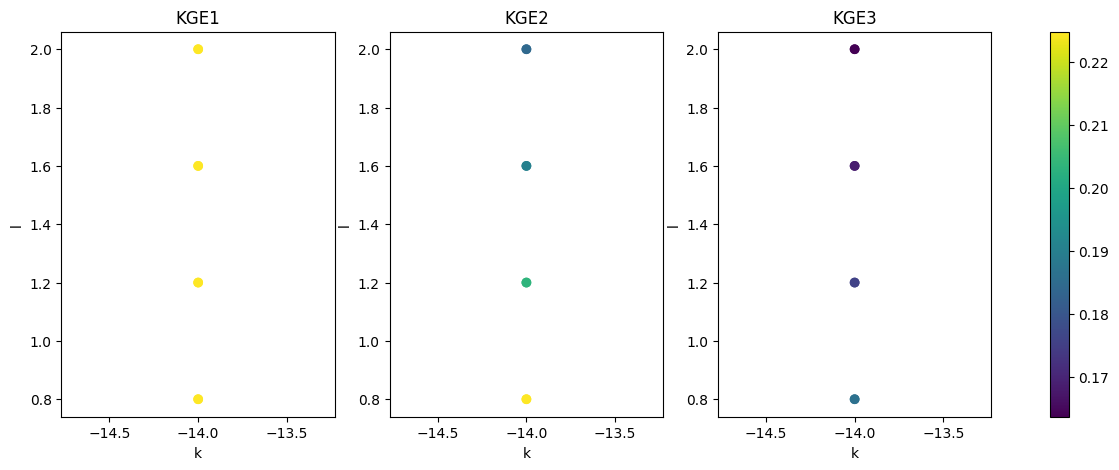

In [246]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the minimum and maximum values of KGE1, KGE2, and KGE3
min_KGE = min(criteria[['KGE1', 'KGE2', 'KGE3']].min())
max_KGE = max(criteria[[ 'KGE2', 'KGE3']].max())

# Create a normalization instance
norm = Normalize(vmin=min_KGE, vmax=max_KGE)

for p in param:
    if p == 'k' and 'l' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('l')
        axs[0].set_title('KGE1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('l')
        axs[1].set_title('KGE2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['l'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('l')
        axs[2].set_title('KGE3')
    elif p == 'k' and 'n' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('n')
        axs[0].set_title('KGE1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('n')
        axs[1].set_title('KGE2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['n'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('n')
        axs[2].set_title('KGE3')
    elif p == 'k' and 'r' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('r')
        axs[0].set_title('KGE1')

        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('r')
        axs[1].set_title('KGE2')

        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['r'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('r')
        axs[2].set_title('KGE3')
        
    elif p == 'k2' and 'k' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k')
        axs[0].set_ylabel('k2')
        axs[0].set_title('KGE1')
        scatter2 = axs[1].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k')
        axs[1].set_ylabel('k2')
        axs[1].set_title('KGE2')
        scatter3 = axs[2].scatter(np.log10(criteria['k']), criteria['k2'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k')
        axs[2].set_ylabel('k2')
        axs[2].set_title('KGE3')
    elif p == 'k2' and 'l2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k2')
        axs[0].set_ylabel('l2')
        axs[0].set_title('KGE1')
        scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k2')
        axs[1].set_ylabel('l2')
        axs[1].set_title('KGE2')
        scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['l2'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k2')
        axs[2].set_ylabel('l2')
        axs[2].set_title('KGE3')
    elif p == 'k2' and 'n2' in param:
        scatter1 = axs[0].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['KGE1'], marker='o', cmap='viridis', norm=norm)
        axs[0].set_xlabel('k2')
        axs[0].set_ylabel('n2')
        axs[0].set_title('KGE1')
        scatter2 = axs[1].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['KGE2'], marker='o', cmap='viridis', norm=norm)
        axs[1].set_xlabel('k2')
        axs[1].set_ylabel('n2')
        axs[1].set_title('KGE2')
        scatter3 = axs[2].scatter(np.log10(criteria['k2']), criteria['n2'], c=criteria['KGE3'], marker='o', cmap='viridis', norm=norm)
        axs[2].set_xlabel('k2')
        axs[2].set_ylabel('n2')
        axs[2].set_title('KGE3')
    

        
            
    # Ajoutez d'autres conditions selon les combinaisons de paramètres nécessaires

# Créer une seule barre de couleur en utilisant le premier scatter plot
colorbar = fig.colorbar(scatter1, ax=axs.ravel().tolist())

plt.show()

In [247]:

path = os.getcwd()
path_output = os.path.join(path, 'OUTPUT')
files = os.listdir(path_output)
files_csv = [f for f in files if f[-3:] == 'csv']
print(files_csv)

['Ref_k_1e-14_Ref_l_1.2_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv', 'Ref_k_1e-14_Ref_l_2.0_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv', 'Ref_k_1e-14_Ref_l_1.6_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv', 'Ref_k_1e-14_Ref_l_0.8_Ref_n_0.8_Ref_r_3500_Ref_k2_1e-13_Ref_l2_2.65_Ref_n2_0.3_Ref_r2_3500.csv']


4


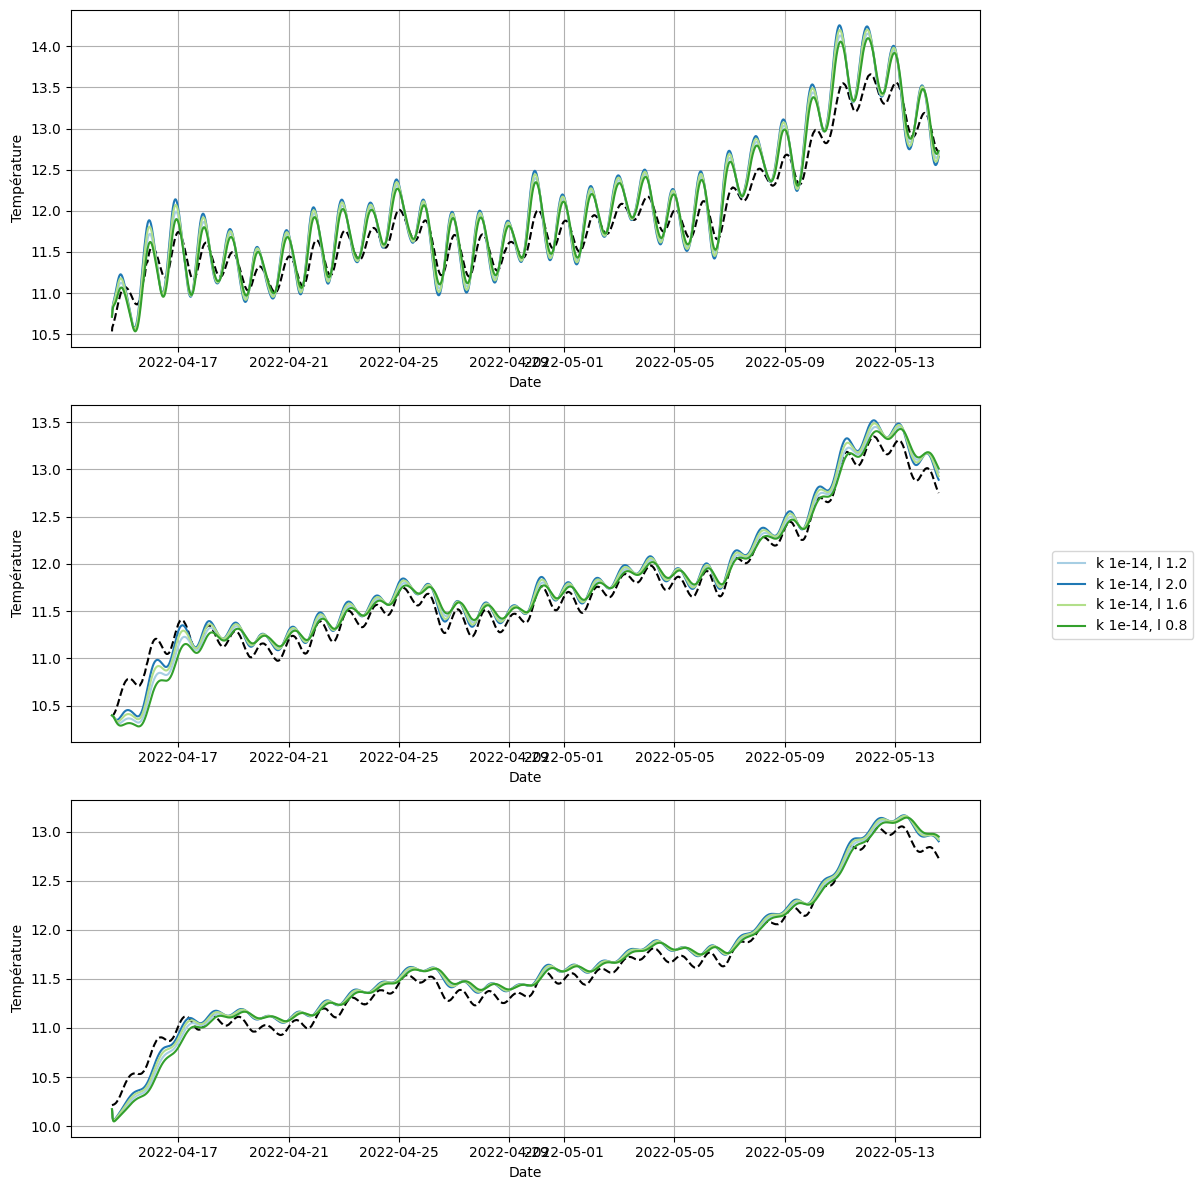

In [248]:
import os
import pandas as pd
import seaborn as sns
import colorcet as cc

# Afficher le nombre de fichiers CSV
print(len(files_csv))

# Définir la palette de couleurs en fonction du nombre de fichiers CSV
if len(files_csv) > 12:
    cmap = sns.color_palette(cc.glasbey, n_colors=len(files_csv))
else:
    cmap = sns.color_palette("Paired", n_colors=len(files_csv))

# Stocker les handles et labels uniques pour la légende globale
legend_dict = {}



# Lire tous les fichiers dans le répertoire OUTPUT
path = os.getcwd()
path_output = os.path.join(path, 'OUTPUT')
files = os.listdir(path_output)
files_csv = [f for f in files if f[-3:] == 'csv']
obs_temp = all_data[(all_data['dates'] > date_simul_bg) & (all_data['dates'] < date_end)]
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
# Tracer les températures observées
for i in range(1, 4):
    axs[i-1].plot(obs_temp['dates'], obs_temp[f'Temp{i}'], linestyle='--', color='black')  # Utiliser noir au lieu de rouge

    # Configurations supplémentaires pour chaque subplot
    axs[i-1].set_xlabel('Date')
    axs[i-1].set_ylabel('Température')
    axs[i-1].grid(True)

for idx, file in enumerate(files_csv):
    # Lire le fichier CSV
    df = pd.read_csv(os.path.join(path_output, file))
    
    # Extraire les valeurs des paramètres du nom du fichier
    try:
        df['Ref_k'] = float(file.split('_')[2])
        df['Ref_l'] = float(file.split('_')[5])
        df['Ref_n'] = float(file.split('_')[8])
        df['Ref_r'] = float(file.split('_')[11].replace('.csv', ''))
        
        if nb_zone == 2:
            df['Ref_k2'] = float(file.split('_')[14])
            df['Ref_l2'] = float(file.split('_')[17])
            df['Ref_n2'] = float(file.split('_')[20])
            df['Ref_r2'] = float(file.split('_')[23].replace('.csv', ''))
    except (IndexError, ValueError) as e:
        print(f"Erreur lors de l'extraction des paramètres du fichier {file}: {e}")
        continue
    
    # Convertir les dates en format datetime
    df['dates'] = pd.to_datetime(df['dates'])
    
    # Filtrer les dates
    sim_temp = df[(df['dates'] > date_simul_bg) & (df['dates'] < date_end)]
    
    # Obtenir la couleur de la palette en utilisant l'indexation de liste
    color = cmap[idx]

    # Déterminer le label en fonction des paramètres présents
    label_parts = []
    if 'k' in param:
        label_parts.append(f"k {df['Ref_k'].iloc[0]}")
    if 'l' in param:
        label_parts.append(f"l {df['Ref_l'].iloc[0]}")
    if 'n' in param:
        label_parts.append(f"n {df['Ref_n'].iloc[0]}")
    if 'r' in param:
        label_parts.append(f"r {df['Ref_r'].iloc[0]}")
    if nb_zone == 2:
        if 'k2' in param:
            label_parts.append(f"k2 {df['Ref_k2'].iloc[0]}")
        if 'l2' in param:
            label_parts.append(f"l2 {df['Ref_l2'].iloc[0]}")
        if 'n2' in param:
            label_parts.append(f"n2 {df['Ref_n2'].iloc[0]}")
        if 'r2' in param:
            label_parts.append(f"r2 {df['Ref_r2'].iloc[0]}")
    label = ", ".join(label_parts)
    
    # Tracer les données avec une couleur graduelle en fonction des valeurs de k, l, n ou r
    for i in range(1, 4):
        line, = axs[i-1].plot(sim_temp['dates'], sim_temp[f'Temp{i}'], 
                              label=label, linestyle='-', color=color)
        axs[i-1].grid(True)
        if label not in legend_dict:
            legend_dict[label] = line

# Déplacer la légende à droite en dehors du graphique
fig.legend(legend_dict.values(), legend_dict.keys(), bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.tight_layout()
plt.show()